In [1]:
from __future__ import annotations # To prevent Subscript for class "list" will generate runtime exception; enclose type annotation in quotes
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import random
# from Kmeans import *
%matplotlib inline
# pd.options.display.max_rows = 4000

/tmp/ipykernel_12233/312240673.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('ml-1m/users.dat', delimiter='::', names=['UserID','Gender','Age','Occupation','Zip-code'], index_col='UserID')
df

/tmp/ipykernel_12233/623960029.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('ml-1m/users.dat', delimiter='::', names=['UserID','Gender','Age','Occupation','Zip-code'], index_col='UserID')


,Gender,Age,Occupation,Zip-code
UserID,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455
...,...,...,...,...
6036,F,25,15,32603
6037,F,45,1,76006
6038,F,56,1,14706


In [3]:
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])
df

,Gender,Age,Occupation,Zip-code
UserID,,,,
1,0,1,10,48067
2,1,56,16,70072
3,1,25,15,55117
4,1,45,7,02460
5,1,25,20,55455
...,...,...,...,...
6036,0,25,15,32603
6037,0,45,1,76006
6038,0,56,1,14706


In [4]:
df['Zip-code'] = df['Zip-code'].apply(lambda x: int(x.split('-')[0]) if type(x)==str else x)
df['Zip-code'] = df['Zip-code'].apply(lambda x: int(str(x)[0]))

In [5]:
df['Zip-code'] = df['Zip-code'].astype('int64')

In [6]:
df.describe()

,Gender,Age,Occupation,Zip-code
count,6040.000000,6040.000000,6040.000000,6040.000000
mean,0.717053,30.639238,8.146854,5.319371
std,0.450468,12.895962,6.329511,2.860588
min,0.000000,1.000000,0.000000,1.000000
25%,0.000000,25.000000,3.000000,3.000000
50%,1.000000,25.000000,7.000000,5.000000
75%,1.000000,35.000000,14.000000,8.000000
max,1.000000,56.000000,20.000000,9.000000


In [7]:
zipcode=df['Zip-code']
df = pd.get_dummies(
    data=df, # dataframe to one hot encode
    columns=["Zip-code"])
df = pd.get_dummies(
    data=df, # dataframe to one hot encode
    columns=["Occupation"])

In [8]:
df

,Gender,Age,Zip-code_1,Zip-code_2,Zip-code_3,Zip-code_4,Zip-code_5,Zip-code_6,Zip-code_7,Zip-code_8,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,1,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,56,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,1,25,False,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,1,45,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,1,25,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,25,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6037,0,45,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
6038,0,56,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
for i in df.columns[2:]:
	lst=[]
	for j in df[i]:
		if(j):
			lst.append(1)
		else:
			lst.append(0)
	df[i]=lst

df

,Gender,Age,Zip-code_1,Zip-code_2,Zip-code_3,Zip-code_4,Zip-code_5,Zip-code_6,Zip-code_7,Zip-code_8,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,56,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1,25,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,45,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,25,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,25,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6037,0,45,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,56,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df['Age'] = df['Age'].apply(lambda x: x/56)

In [11]:
df

,Gender,Age,Zip-code_1,Zip-code_2,Zip-code_3,Zip-code_4,Zip-code_5,Zip-code_6,Zip-code_7,Zip-code_8,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,0.017857,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1.000000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0.446429,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0.803571,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0.446429,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0.446429,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6037,0,0.803571,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,1.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
ratings=pd.read_csv('ml-1m/ratings.dat', delimiter='::', names=['UserID','MovieID','Rating','TimeStamp'])

/tmp/ipykernel_12233/370879453.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings=pd.read_csv('ml-1m/ratings.dat', delimiter='::', names=['UserID','MovieID','Rating','TimeStamp'])


In [13]:
ratings.describe()

,UserID,MovieID,Rating,TimeStamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [14]:
mean=ratings.loc[:, 'Rating'].mean()
std=ratings.loc[:, 'Rating'].std()
rating = ratings['Rating'].apply(lambda x: (x-mean)/ std)
min=ratings.loc[:, 'Rating'].min()
max=ratings.loc[:, 'Rating'].max()
rating = ratings['Rating'].apply(lambda x: (x-min)/ (max-min))
ratings['Rating']=rating
# min=ratings.loc[:, 'TimeStamp'].min()
# ratings['TimeStamp'] = ratings['TimeStamp'].apply(lambda x: x-min)

In [15]:
ratings

,UserID,MovieID,Rating,TimeStamp
0,1,1193,1.00,978300760
1,1,661,0.50,978302109
2,1,914,0.50,978301968
3,1,3408,0.75,978300275
4,1,2355,1.00,978824291
...,...,...,...,...
1000204,6040,1091,0.00,956716541
1000205,6040,1094,1.00,956704887
1000206,6040,562,1.00,956704746
1000207,6040,1096,0.75,956715648


In [16]:
ratings.sort_values(by=['TimeStamp'],inplace=True)

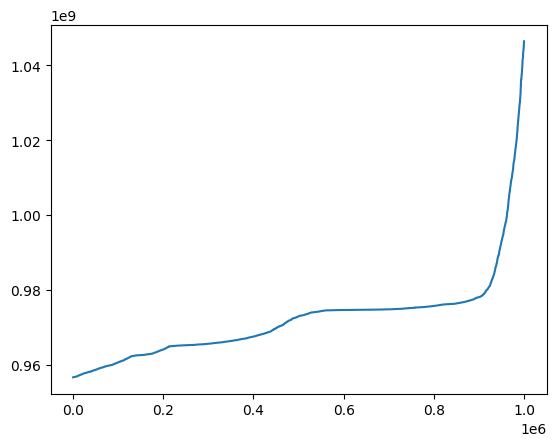

In [17]:
tmp=list(ratings['TimeStamp'])
plt.plot(range(len(tmp)),tmp)
plt.show()

In [18]:
ratings.describe()

,UserID,MovieID,Rating,TimeStamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,6.453911e-01,9.722437e+08
std,1.728413e+03,1.096041e+03,2.792755e-01,1.215256e+07
min,1.000000e+00,1.000000e+00,0.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,5.000000e-01,9.653026e+08
50%,3.070000e+03,1.835000e+03,7.500000e-01,9.730180e+08
75%,4.476000e+03,2.770000e+03,7.500000e-01,9.752209e+08
max,6.040000e+03,3.952000e+03,1.000000e+00,1.046455e+09


In [19]:
movies=pd.read_csv('ml-1m/movies.dat', delimiter='::', names=["Title","Genres"],  encoding="ISO-8859-1")

/tmp/ipykernel_12233/216879354.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies=pd.read_csv('ml-1m/movies.dat', delimiter='::', names=["Title","Genres"],  encoding="ISO-8859-1")


In [20]:
movies['Genres'] = movies['Genres'].apply(lambda x: x.split("|"))

In [21]:
decade_set=[]
for i in movies.index:
    title=movies.at[i,'Title']
    decade=title[-5:-2]
    decade=str(decade)+'0s'
    movies.at[i,'Genres'].append(decade)
    decade_set.append(decade)

In [22]:
decades=[]
for i in set(decade_set):
    decades.append(i)
decades

['1970s',
 '1950s',
 '1960s',
 '1990s',
 '1980s',
 '1940s',
 '1920s',
 '2000s',
 '1930s',
 '1910s']

In [23]:
movies

,Title,Genres
1,Toy Story (1995),"[Animation, Children's, Comedy, 1990s]"
2,Jumanji (1995),"[Adventure, Children's, Fantasy, 1990s]"
3,Grumpier Old Men (1995),"[Comedy, Romance, 1990s]"
4,Waiting to Exhale (1995),"[Comedy, Drama, 1990s]"
5,Father of the Bride Part II (1995),"[Comedy, 1990s]"
...,...,...
3948,Meet the Parents (2000),"[Comedy, 2000s]"
3949,Requiem for a Dream (2000),"[Drama, 2000s]"
3950,Tigerland (2000),"[Drama, 2000s]"
3951,Two Family House (2000),"[Drama, 2000s]"


In [24]:
Genres=["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]+decades
random.Random(4).shuffle(Genres)
tmp=[[] for _ in range(6040)]
for i in Genres:
    df[i]=tmp
df['LastLog']=np.nan

In [25]:
Genres

['Documentary',
 'Sci-Fi',
 'Musical',
 '1910s',
 'War',
 '1970s',
 'Western',
 'Horror',
 '1980s',
 '1950s',
 '1990s',
 'Crime',
 'Romance',
 'Fantasy',
 '2000s',
 'Adventure',
 '1930s',
 '1920s',
 'Action',
 '1960s',
 'Animation',
 'Comedy',
 'Thriller',
 'Mystery',
 '1940s',
 "Children's",
 'Film-Noir',
 'Drama']

In [26]:
df

,Gender,Age,Zip-code_1,Zip-code_2,Zip-code_3,Zip-code_4,Zip-code_5,Zip-code_6,Zip-code_7,Zip-code_8,...,1960s,Animation,Comedy,Thriller,Mystery,1940s,Children's,Film-Noir,Drama,LastLog
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,0.017857,0,0,0,1,0,0,0,0,...,[],[],[],[],[],[],[],[],[],NaN
2,1,1.000000,0,0,0,0,0,0,1,0,...,[],[],[],[],[],[],[],[],[],NaN
3,1,0.446429,0,0,0,0,1,0,0,0,...,[],[],[],[],[],[],[],[],[],NaN
4,1,0.803571,0,1,0,0,0,0,0,0,...,[],[],[],[],[],[],[],[],[],NaN
5,1,0.446429,0,0,0,0,1,0,0,0,...,[],[],[],[],[],[],[],[],[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0.446429,0,0,1,0,0,0,0,0,...,[],[],[],[],[],[],[],[],[],NaN
6037,0,0.803571,0,0,0,0,0,0,1,0,...,[],[],[],[],[],[],[],[],[],NaN
6038,0,1.000000,1,0,0,0,0,0,0,0,...,[],[],[],[],[],[],[],[],[],NaN


In [27]:
# pd.options.display.max_rows = 4000
for j in ratings.index:
    uid,mid,rating,time=ratings.iloc[j]
    uid=int(uid)
    mid=int(mid)
    time=int(time)
    try:
        genres=movies.at[mid,"Genres"]
        for i in genres:
            temp = df.at[uid,i]
            if(len(temp)==0 or time-temp[1]>=31536000):
                temp=[rating,time]
            else:
                temp=[rating+temp[0]*(1-(time-temp[1])/31536000),time]
            df.at[uid,i]=temp
            df.at[uid,"LastLog"]=time
    except:
        pass

In [28]:
df

,Gender,Age,Zip-code_1,Zip-code_2,Zip-code_3,Zip-code_4,Zip-code_5,Zip-code_6,Zip-code_7,Zip-code_8,...,1960s,Animation,Comedy,Thriller,Mystery,1940s,Children's,Film-Noir,Drama,LastLog
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,0.017857,0,0,0,1,0,0,0,0,...,"[3.2499574190239757, 978301968]","[14.144793851519703, 978302109]","[11.066062346975686, 978302268]","[2.008262398687079, 978302091]",[],"[2.4999856037789696, 978302281]","[16.386502852189857, 978302109]",[],"[18.02844869003777, 978302281]",978302109.0
2,1,1.000000,0,0,0,0,0,0,1,0,...,"[7.000051947919965, 978298434]",[],"[16.00044701949139, 978298434]","[19.25070607790844, 978298517]","[1.7499988901454557, 978300025]","[1.5000104880136986, 978298517]",[],"[0.75, 978298958]","[57.2503574321624, 978298730]",978298730.0
3,1,0.446429,0,0,0,0,1,0,0,0,...,"[1.7500188990360224, 978297570]","[2.249991295674266, 978298504]","[20.749855186801383, 978298147]","[3.500064259740083, 978297018]","[0.5, 978297867]",[],"[2.249991295674266, 978298504]",[],"[6.000079574331893, 978297018]",978297018.0
4,1,0.803571,0,1,0,0,0,0,0,0,...,"[3.749988013660682, 978294282]",[],[],"[2.500000523159496, 978294260]",[],[],"[0.75, 978293964]",[],"[4.7499809185839545, 978294282]",978294282.0
5,1,0.446429,0,0,0,0,1,0,0,0,...,"[0.5, 978242847]","[3.0000855451421566, 978241981]","[33.74768272623626, 978246479]","[17.999769212709737, 978245334]","[4.250094390110508, 978244025]","[1.0, 978242740]","[4.250238405990451, 978241981]","[2.2499389193828674, 978244025]","[54.498729640030845, 978245334]",978245334.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0.446429,0,0,1,0,0,0,0,0,...,"[29.71583500108898, 956752783]","[24.725339868236908, 956753886]","[143.6260748608145, 956753853]","[78.67904415584066, 956753853]","[20.480319622094477, 956753853]","[14.250196198028382, 956712810]","[32.976208422941646, 956753853]","[12.986503105851153, 956753853]","[232.77249510598617, 956753853]",956753853.0
6037,0,0.803571,0,0,0,0,0,0,1,0,...,"[18.258155217504427, 956709355]","[0.75, 956719174]","[38.01297065206495, 956709215]","[46.02218522785525, 956708997]","[8.752083836570524, 956709701]","[10.001432512838457, 956709173]","[4.00202694113177, 956709303]","[5.502699635004143, 956708997]","[70.51346894583072, 956709355]",956709355.0
6038,0,1.000000,1,0,0,0,0,0,0,0,...,"[0.5, 956707604]","[1.9999958777270421, 956707734]","[8.499980214511837, 956707604]",[],[],[],"[0.5, 956706827]",[],"[6.5009455081750644, 956706827]",956707604.0


In [29]:
df_off=df.copy()
for i in Genres:
    for j in df_off.index:
        temp=df_off.at[j,i]
        try:
            if(df_off.at[j,"LastLog"]<=31536000):
                df_off.at[j,i]=temp[0]*(temp[1]/df_off.at[j,"LastLog"])
            else:
                if(df_off.at[j,"LastLog"]-temp[1]>=31536000):
                    df_off.at[j,i]=0
                else:
                    df_off.at[j,i]=temp[0]*(1-(df_off.at[j,"LastLog"]-temp[1])/31536000)
        except:
            df_off.at[j,i]=np.nan

In [30]:
df_off

,Gender,Age,Zip-code_1,Zip-code_2,Zip-code_3,Zip-code_4,Zip-code_5,Zip-code_6,Zip-code_7,Zip-code_8,...,1960s,Animation,Comedy,Thriller,Mystery,1940s,Children's,Film-Noir,Drama,LastLog
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,0.017857,0,0,0,1,0,0,0,0,...,3.249943,14.144794,11.066118,2.008261,NaN,2.499999,16.386503,NaN,18.028547,978302109.0
2,1,1.000000,0,0,0,0,0,0,1,0,...,6.999986,NaN,16.000297,19.250576,1.750071,1.5,NaN,0.750005,57.250357,978298730.0
3,1,0.446429,0,0,0,0,1,0,0,0,...,1.75005,2.250097,20.750598,3.500064,0.500013,NaN,2.250097,NaN,6.00008,978297018.0
4,1,0.803571,0,1,0,0,0,0,0,0,...,3.749988,NaN,NaN,2.499999,NaN,NaN,0.749992,NaN,4.749981,978294282.0
5,1,0.446429,0,0,0,0,1,0,0,0,...,0.499961,2.999767,33.748908,17.999769,4.249918,0.999918,4.249787,2.249846,54.49873,978245334.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0.446429,0,0,1,0,0,0,0,0,...,29.714827,24.725366,143.626075,78.679044,20.48032,14.23165,32.976208,12.986503,232.772495,956753853.0
6037,0,0.803571,0,0,0,0,0,0,1,0,...,18.258155,0.750234,38.012802,46.021663,8.75218,10.001375,4.00202,5.502637,70.513469,956709355.0
6038,0,1.000000,1,0,0,0,0,0,0,0,...,0.5,2.000004,8.49998,NaN,NaN,NaN,0.499988,NaN,6.500785,956707604.0


In [31]:
df_off.isna().sum().sum()

36697

In [32]:
df_off.drop(["LastLog"],axis=1,inplace=True)
df_off['Zip-code']=zipcode
grouped = df_off.groupby(['Age','Gender','Zip-code'])
grouped.count()

Zip-code_1  Zip-code_2  Zip-code_3  Zip-code_4  \
Age      Gender Zip-code                                                   
0.017857 0      1                 15          15          15          15   
                2                 12          12          12          12   
                3                  3           3           3           3   
                4                  9           9           9           9   
                5                 11          11          11          11   
...                              ...         ...         ...         ...   
1.000000 1      5                 25          25          25          25   
                6                 15          15          15          15   
                7                 22          22          22          22   
                8                 16          16          16          16   
                9                 62          62          62          62   

                          Zip-code_5  Zip-code_6  Zip-code_7  Zip-code_8  \
Age      Gender Zip-code                                                   
0.017857 0      1                 15          15          15          15   
                2                 12          12          12          12   
                3                  3           3           3           3   
                4                  9           9           9           9   
                5                 11          11          11          11   
...                              ...         ...         ...         ...   
1.000000 1      5                 25          25          25          25   
                6                 15          15          15          15   
                7                 22          22          22          22   
                8                 16          16          16          16   
                9                 62          62          62          62   

                          Zip-code_9  Occupation_0  ...  Action  1960s  \
Age      Gender Zip-code                            ...                  
0.017857 0      1                 15            15  ...      15     11   
                2                 12            12  ...      11     10   
                3                  3             3  ...       3      2   
                4                  9             9  ...       9      8   
                5                 11            11  ...      11      8   
...                              ...           ...  ...     ...    ...   
1.000000 1      5                 25            25  ...      25     24   
                6                 15            15  ...      15     14   
                7                 22            22  ...      22     19   
                8                 16            16  ...      16     14   
                9                 62            62  ...      62     54   

                          Animation  Comedy  Thriller  Mystery  1940s  \
Age      Gender Zip-code                                                
0.017857 0      1                13      15        14       11      9   
                2                10      12        12        8      8   
                3                 3       3         3        3      3   
                4                 9       9         8        5      6   
                5                 9      11        10        8      6   
...                             ...     ...       ...      ...    ...   
1.000000 1      5                15      25        24       21     17   
                6                 9      15        15       12     10   
                7                15      22        22       19     16   
                8                 8      16        15       13     13   
                9                48      62        61       55     42   

                          Children's  Film-Noir  Drama  
Age      Gender Zip-code                                
0.017857 0      1    

In [33]:
for i in Genres:
    df_off[i] = grouped[i].transform(lambda x: x.fillna(x.mean()))

/tmp/ipykernel_12233/2493534153.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_off[i] = grouped[i].transform(lambda x: x.fillna(x.mean()))


In [34]:
df_off.isna().sum().sum()

4386

In [35]:
for i in Genres:
    df_off[i].fillna(df_off[i].mean(), inplace=True)

/tmp/ipykernel_12233/1492491197.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_off[i].fillna(df_off[i].mean(), inplace=True)


In [36]:
df_off.isna().sum().sum()

0

In [37]:
df_off.drop("Zip-code",axis=1,inplace=True)

In [38]:
df_off

,Gender,Age,Zip-code_1,Zip-code_2,Zip-code_3,Zip-code_4,Zip-code_5,Zip-code_6,Zip-code_7,Zip-code_8,...,Action,1960s,Animation,Comedy,Thriller,Mystery,1940s,Children's,Film-Noir,Drama
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,0.017857,0,0,0,1,0,0,0,0,...,3.999940,3.249943,14.144794,11.066118,2.008261,1.617789,2.499999,16.386503,0.103063,18.028547
2,1,1.000000,0,0,0,0,0,0,1,0,...,35.001047,6.999986,2.067104,16.000297,19.250576,1.750071,1.500000,3.744933,0.750005,57.250357
3,1,0.446429,0,0,0,0,1,0,0,0,...,17.000350,1.750050,2.250097,20.750598,3.500064,0.500013,3.631821,2.250097,3.051451,6.000080
4,1,0.803571,0,1,0,0,0,0,0,0,...,14.999969,3.749988,8.490906,41.325086,2.499999,7.503882,6.437785,0.749992,4.835141,4.749981
5,1,0.446429,0,0,0,0,1,0,0,0,...,12.499860,0.499961,2.999767,33.748908,17.999769,4.249918,0.999918,4.249787,2.249846,54.498730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0.446429,0,0,1,0,0,0,0,0,...,76.944285,29.714827,24.725366,143.626075,78.679044,20.480320,14.231650,32.976208,12.986503,232.772495
6037,0,0.803571,0,0,0,0,0,0,1,0,...,18.525389,18.258155,0.750234,38.012802,46.021663,8.752180,10.001375,4.002020,5.502637,70.513469
6038,0,1.000000,1,0,0,0,0,0,0,0,...,0.999978,0.500000,2.000004,8.499980,6.856607,2.541639,3.727273,0.499988,1.575006,6.500785


In [39]:
ToNormalize=df_off[Genres]
min=ToNormalize.min(axis=1)
max=ToNormalize.max(axis=1)
# print(min,max)
for i in ToNormalize.index:
    for j in Genres:
        if(max[i]==min[i]):
            pass
        else:
            ToNormalize.at[i,j]=(ToNormalize.at[i,j]-min[i])/(max[i]-min[i])
# ToNormalize=ToNormalize.apply(lambda x:(x-min)/max, axis=1)
for i in Genres:
    df_off[i]=ToNormalize[i]

In [40]:
df_off.isna().sum().sum()

0

In [41]:
df_off

,Gender,Age,Zip-code_1,Zip-code_2,Zip-code_3,Zip-code_4,Zip-code_5,Zip-code_6,Zip-code_7,Zip-code_8,...,Action,1960s,Animation,Comedy,Thriller,Mystery,1940s,Children's,Film-Noir,Drama
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,0.017857,0,0,0,1,0,0,0,0,...,0.182449,0.148240,0.645186,0.504759,0.091603,7.379219e-02,0.114032,0.747438,0.004701,0.822336
2,1,1.000000,0,0,0,0,0,0,1,0,...,0.607944,0.114536,0.027614,0.273131,0.330404,2.202718e-02,0.017621,0.057179,0.004405,1.000000
3,1,0.446429,0,0,0,0,1,0,0,0,...,0.814808,0.061729,0.086422,1.000000,0.148147,6.255649e-07,0.154653,0.086422,0.125994,0.271601
4,1,0.803571,0,1,0,0,0,0,0,0,...,0.354289,0.078345,0.194632,1.000000,0.047685,1.704221e-01,0.144273,0.004760,0.104962,0.102874
5,1,0.446429,0,0,0,0,1,0,0,0,...,0.125002,0.000000,0.026040,0.346350,0.182293,3.906287e-02,0.005208,0.039062,0.018228,0.562499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0.446429,0,0,1,0,0,0,0,0,...,0.294317,0.111286,0.091950,0.552734,0.301040,7.549845e-02,0.051283,0.123925,0.046457,0.898209
6037,0,0.803571,0,0,0,0,0,0,1,0,...,0.257441,0.253624,0.003553,0.535784,0.650177,1.178472e-01,0.135690,0.049999,0.071433,1.000000
6038,0,1.000000,1,0,0,0,0,0,0,0,...,0.062499,0.000002,0.187502,1.000000,0.794578,2.552067e-01,0.403411,0.000000,0.134377,0.750100


In [42]:
df_off.to_csv('preprocessed.csv')

In [43]:
pd.DataFrame(Genres).to_csv('genre_order.csv')